# Anatomy of a neural networkm
## Layers: the building blocks of deep learning

In [60]:
from keras import layers
from keras import models
import time
import numpy as np
from keras.models import load_model
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))

In [2]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [3]:
np.__version__

'1.16.2'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18348197267189237737
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4941820723
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12221694754867815455
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
Total params: 26,176
Trainable params: 26,176
Non-trainable params: 0
_________________________________________________________________


In [6]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import log_loss
# clf = DummyClassifier('most_frequent', constant=0)
# clf.fit(partial_x_train, partial_y_train)
# clf.score(x_val, y_val)

# Classifying movie reviews: a binary classification example

In [7]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [8]:
print(f"Training data size {len(train_data)}, Test data set : {len(test_data)}")
print(f"Max index: {max({max(sequence) for sequence in train_data})}")

Training data size 25000, Test data set : 25000
Max index: 9999


In [9]:
word_index = imdb.get_word_index()
reserve_word_index = {value:key for (key, value) in word_index.items()}

In [10]:
def decode(input_vec):
    # Mapping a index vector into str
    return ' '.join([reserve_word_index[idx] for idx in input_vec])

In [11]:
decode(train_data[50])

"the was look least as on they is dull movie sometimes movie was scenario of and only sense would takes seen jack was me best says they is dull new it's he's even and movie sometimes movie was says though jack was real one out and additional additional in only pleasant to kept line not even and was cinema this to plays of on as on nothing could especially this of dull dark his which true his which and episodes bad superman more this deceased worthless us theater since it's her play story wholesome as on floor of night story wrenching and them expected more this deceased spirit worthless but funny theater since"

## Preparing the data

In [12]:
import numpy as np

In [13]:
def vectorize_sequences(sequences, dim = 10000):
    results = np.zeros((len(sequences), dim))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [14]:
%%time
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Wall time: 2.42 s


In [15]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

## Building your network

In [75]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                 loss = 'binary_crossentropy',
                 metrics=['accuracy', 'mse'])
    return model

In [76]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 160,593
Trainable params: 160,593
Non-trainable params: 0
_________________________________________________________________


In [78]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [79]:
get_model_memory_usage(1024, model)

0.613

In [80]:
def show_result(history, bath_size):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1, len(history.epoch)+1)
    fig, axs = plt.subplots(1,2, figsize=(16,7))
    fig.suptitle(f'Epoch {bath_size}')
    axs[0].plot(epochs, loss_values, 'bo', label='Training loss')
    axs[0].plot(epochs, val_loss_values, 'b', label='Validation loss')
    axs[0].set_title('Traning and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    axs[1].plot(epochs, acc_values, 'bo', label='Training acc')
    axs[1].plot(epochs, val_acc_values, 'b', label='Validation acc')
    axs[1].set_title('Traning and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()
    

In [81]:
batch_sizes = [256,512, 1024,2048]
hist_recoder = []
result_recoder = []
time_recoder = []

In [82]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

config = tf.ConfigProto(intra_op_parallelism_threads=4,
        inter_op_parallelism_threads=1, allow_soft_placement=True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

KTF.set_session(session)

25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

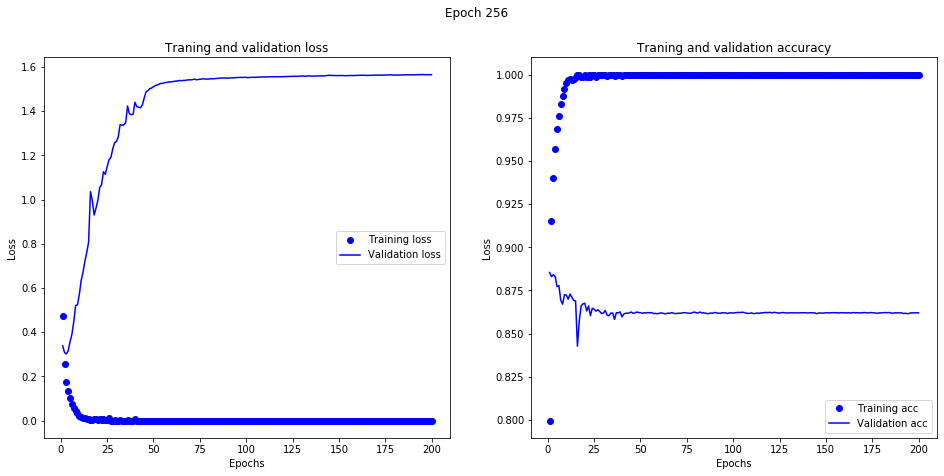

25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 194us/step


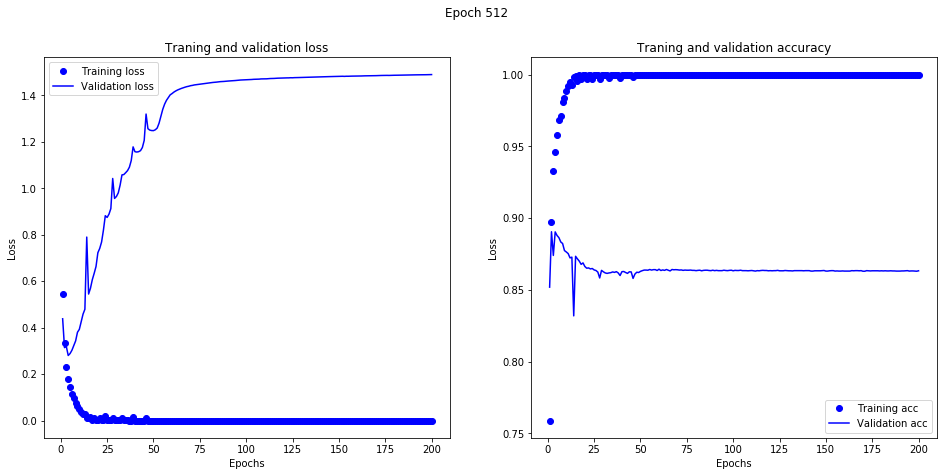

25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 193us/step


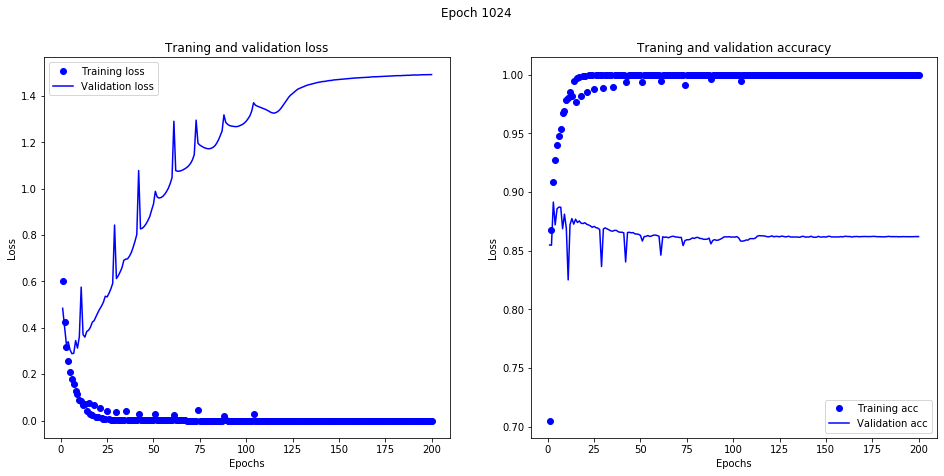

25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 193us/step


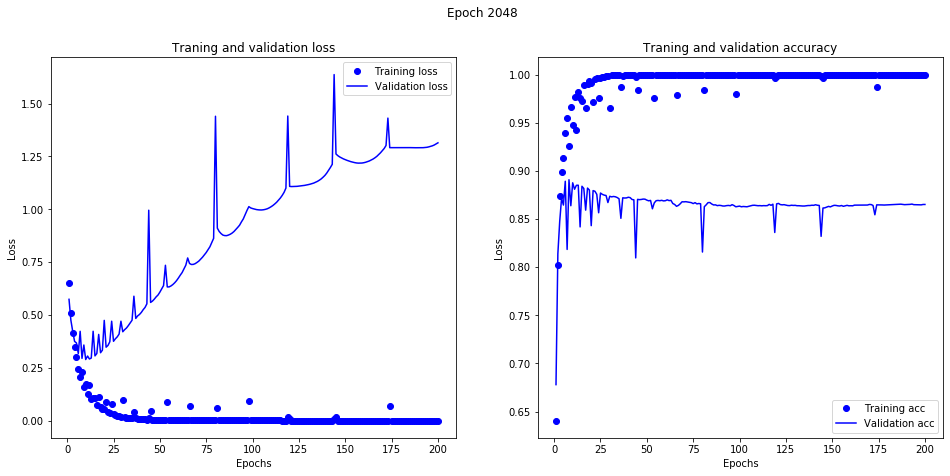

In [83]:
model = build_model()
Wsave = model.get_weights()

for batch_size in tqdm(batch_sizes):
    model.set_weights(Wsave)
    start=time.time()

    history = model.fit(partial_x_train, partial_y_train,
                       epochs=200, batch_size=batch_size,
                       validation_data=(x_val, y_val), verbose=0)
    result = model.evaluate(x=x_test, y=y_test)
    end=time.time()
    hist_recoder.append(history)
    time_recoder.append(end-start)
    result_recoder.append(result)
    model.save('model_16_32_batchsize_{batch_size}.h5')
    show_result(history,batch_size)

In [84]:
result_recoder = np.array(result_recoder)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


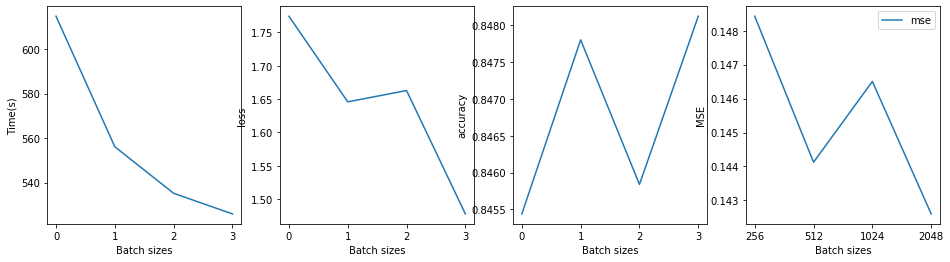

In [85]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].plot(range(len(batch_sizes)), time_recoder)
axs[0].set_xlabel('Batch sizes')
axs[0].set_ylabel('Time(s)')
plt.xticks(range(len(batch_sizes)), labels=batch_sizes)


axs[1].plot(range(len(batch_sizes)), result_recoder[:, 0], label='loss')
axs[1].set_xlabel('Batch sizes')
axs[1].set_ylabel('loss')
plt.xticks(range(len(batch_sizes)), labels=batch_sizes)
plt.legend()

axs[2].plot(range(len(batch_sizes)), result_recoder[:, 1], label='accuray')
axs[2].set_xlabel('Batch sizes')
axs[2].set_ylabel('accuracy')
plt.xticks(range(len(batch_sizes)), labels=batch_sizes)
plt.legend()

axs[3].plot(range(len(batch_sizes)), result_recoder[:, 2], label='mse')
axs[3].set_xlabel('Batch sizes')
axs[3].set_ylabel('MSE')
plt.xticks(range(len(batch_sizes)), labels=batch_sizes)
plt.legend()

In [86]:
history

In [87]:
对于下列网络， 我们看到

Layer (type)                 Output Shape              Param #   
=================================================================
dense_6 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
=================================================================
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________


SyntaxError: invalid character in identifier (<ipython-input-87-129aa872315e>, line 1)

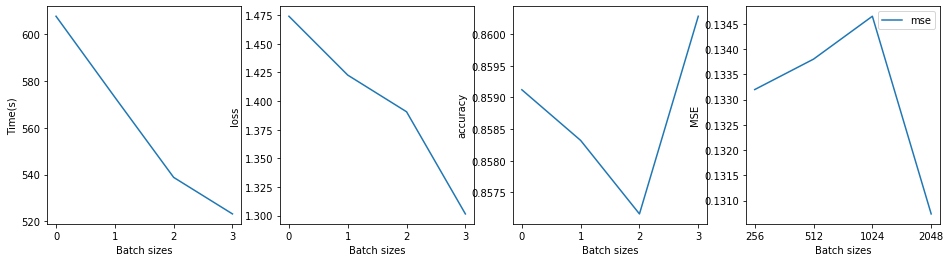

<div class='alert alert-info'>
    增加batch size可以减少每个epoch使用的时间， 但是收敛速度更慢， 需要更多的epoch来使结果收敛。似乎看起来如果batch-size越高， 过拟合程度越低，但是很有可能是增加batch-size收敛速度太慢导致的， 与early-stoping原理类似.但经过比较也可以发现，在采用early-stop的情况下， batch-size越大， 最好的情况越好， 换言之提高batch-size确实可以提高准确率
    
 即使是最差的情况， 该模型效果也优于随机猜测，可以认为这个模型是有效的。
    
 当Epoch为20时， 时间在56s到63s，只使用CPU时间并没有很大改变，打印设备log会拖慢运行速度。
 数据GPU的优势并没有发挥出来。训练的时候可以通过增加线程来节约数据处理的时间， 开启多线程CPU， GPU占用率没有明显增加。 数据集较小的情况下，数据在CPU与GPU传递过程中，会消耗很多时间，可能会拖慢速度
 
 增加网络的宽度，能够极大的减少最快情况的loss与准确率。 换言之， 增加网络宽度，能够明显改善网络性能。
 
 目前的词袋模型很容易过拟合，增加epoch的大小，对于该模型效果并不好
</div>

In [ ]:
history.history.keys()

In [ ]:
hist_recoder[1].epoch

In [ ]:
plt.clf()
fig, axs_loss = plt.subplots(1,2, figsize=(16,5))
fig, axs_acc = plt.subplots(1,2, figsize=(16,5))
fig, axs_mse = plt.subplots(1,2, figsize=(16,5))

for idx, batch_size in enumerate(batch_sizes):
    history_dict = hist_recoder[idx].history
    
    loss_values = history_dict['loss']
    axs_loss[0].plot(history.epoch ,loss_values, label=f'{batch_size}')
    axs_loss[0].set_xticks(history.epoch)
    axs_loss[0].set_title('Training loss')
    axs_loss[0].legend()
    
    
    val_loss_values = history_dict['val_loss']
    axs_loss[1].plot(history.epoch ,val_loss_values, label=f'{batch_size}')
    axs_loss[1].set_title('Validate loss')
    axs_loss[1].set_xticks(history.epoch)
    axs_loss[1].legend()
    
    
    acc_values = history_dict['acc']
    axs_acc[0].plot(history.epoch ,acc_values, label=f'{batch_size}')
    axs_acc[0].set_xticks(history.epoch)
    axs_acc[0].set_title('Training Acc')
    axs_acc[0].legend()
    
    val_acc_values = history_dict['val_acc']
    axs_acc[1].plot(history.epoch ,val_acc_values, label=f'{batch_size}')
    axs_acc[1].set_title('Validate accuracy')
    axs_acc[1].set_xticks(history.epoch)
    axs_acc[1].legend()
    
    
    mse_values = history_dict['mean_squared_error']
    axs_mse[0].plot(history.epoch ,mse_values, label=f'{batch_size}')
    axs_mse[0].set_title('train mean_squared_error')
    axs_mse[0].set_xticks(history.epoch)
    axs_mse[0].legend()
    
    val_mse_values = history_dict['val_mean_squared_error']
    axs_mse[1].plot(history.epoch ,val_mse_values, label=f'{batch_size}')
    axs_mse[1].set_title('Validate mean_squared_error')
    axs_mse[1].set_xticks(history.epoch)
    axs_mse[1].legend()
#     mean_squared_error

In [ ]:
for idx, batch_size in enumerate(batch_sizes):
    history_dict = hist_recoder[idx].history
    val_loss_values = history_dict['loss']
   
    plt.plot(history.epoch ,loss_values, label=f'{batch_size}')
    plt.title('Training loss')
    plt.legend()
    